## Example for reading tif images
How to read and view channels in a multiband tiff image

In [1]:
import numpy as np
import os
import skimage.io as skio
import matplotlib.pyplot as plt
import pandas as pd

#### Display channels in a single image from EuroSat data

In [2]:
## Example with a single image from EuroSat data

## Read images
indir = '../inputs/'
f_rgb = os.path.join(indir, 'data_small', 'rgb', 'Residential', 'Residential_1038.jpg')
f_mb = os.path.join(indir, 'data_small', 'multiband', 'Residential', 'Residential_1038.tif')

mat_rgb = skio.imread(f_rgb)
mat_mb = skio.imread(f_mb, plugin="tifffile")

In [3]:
print('Img size RGB: ' + str(mat_rgb.shape))
print('Img size Multiband: ' + str(mat_mb.shape))

Img size RGB: (64, 64, 3)
Img size Multiband: (64, 64, 13)


RGB image channels:


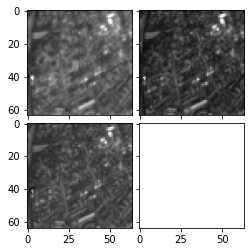

In [4]:
## Display channels in a grid   
# (https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Make a list of channels (for visualization purposes here)
# Move the last axis (channels) to first axis and convert to list
channels_rgb = list(np.moveaxis(mat_rgb,2,0))
channels_mb = list(np.moveaxis(mat_mb,2,0))

## Create an image grid
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  nrows_ncols=(2, 2), axes_pad=0.1)

## Show each channel in the image grid
print('RGB image channels:')
for ax, im in zip(grid, channels_rgb):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
plt.show()

Multiband image channels:


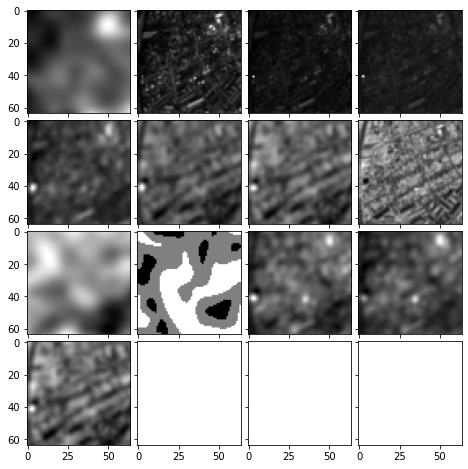

In [5]:
## Create an image grid
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  nrows_ncols=(4, 4), axes_pad=0.1)

## Show each channel in the image grid
print('Multiband image channels:')
for ax, im in zip(grid, channels_mb):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
plt.show()

#### Example application: Detect RGB channels in Multiband image

In [6]:
## Compare each band in RBG image to Multiband image 

## Flatten channels (for calculating image similarity)
# Move the last axis (channels) to first axis and reshape to a 2D array
mat2d_rgb = np.moveaxis(mat_rgb,2,0).reshape(3,-1)
mat2d_mb = np.moveaxis(mat_mb,2,0).reshape(13,-1)


In [7]:
## Create a dataframe with pixel values for each channel
df_rgb = pd.DataFrame(columns = ['RGB_' + str(x) for x in range(mat2d_rgb.shape[0])], data = mat2d_rgb.T).astype(float)
df_mb = pd.DataFrame(columns = ['MB_' + str(x) for x in range(mat2d_mb.shape[0])], data = mat2d_mb.T).astype(float)
df = pd.concat([df_rgb, df_mb], axis = 1)

## Smaller dataframe with a subset of channels
df_mb_subset = df_mb[df_mb.columns[0:5]]
df_subset = pd.concat([df_rgb, df_mb_subset], axis = 1)

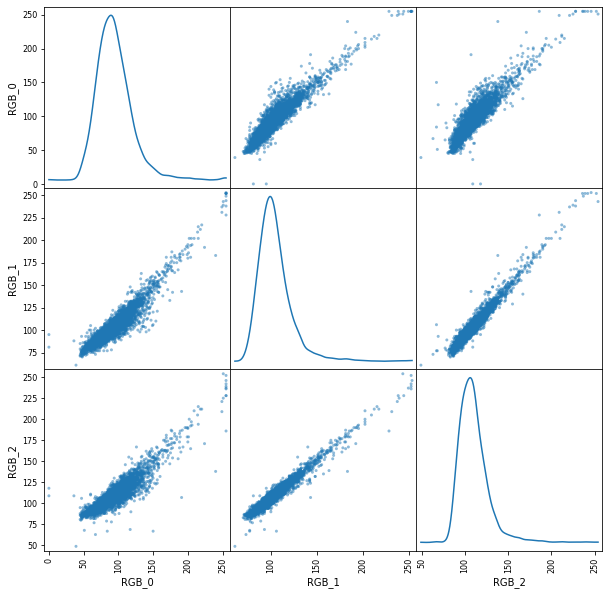

In [8]:
## Plot correlations between channels (RGB)
pd.plotting.scatter_matrix(df_rgb, alpha=0.5, figsize=(10, 10), diagonal='kde')
plt.show()

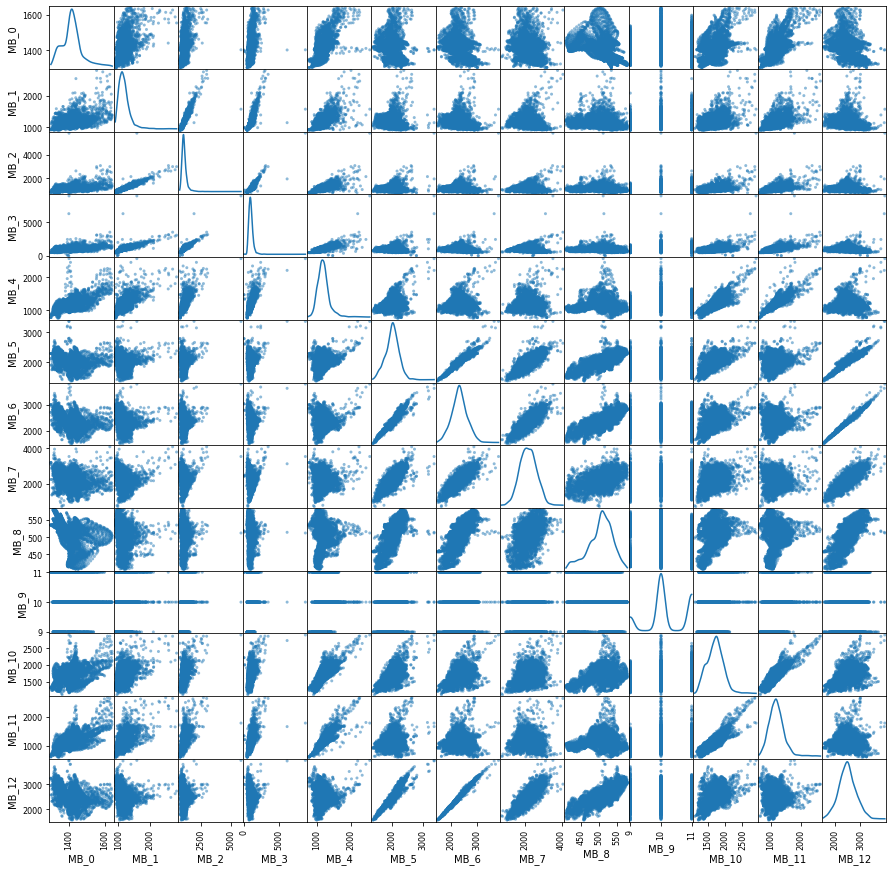

In [9]:
## Plot correlations between channels (Multiband)
pd.plotting.scatter_matrix(df_mb, alpha=0.5, figsize=(15, 15), diagonal='kde')
plt.show()

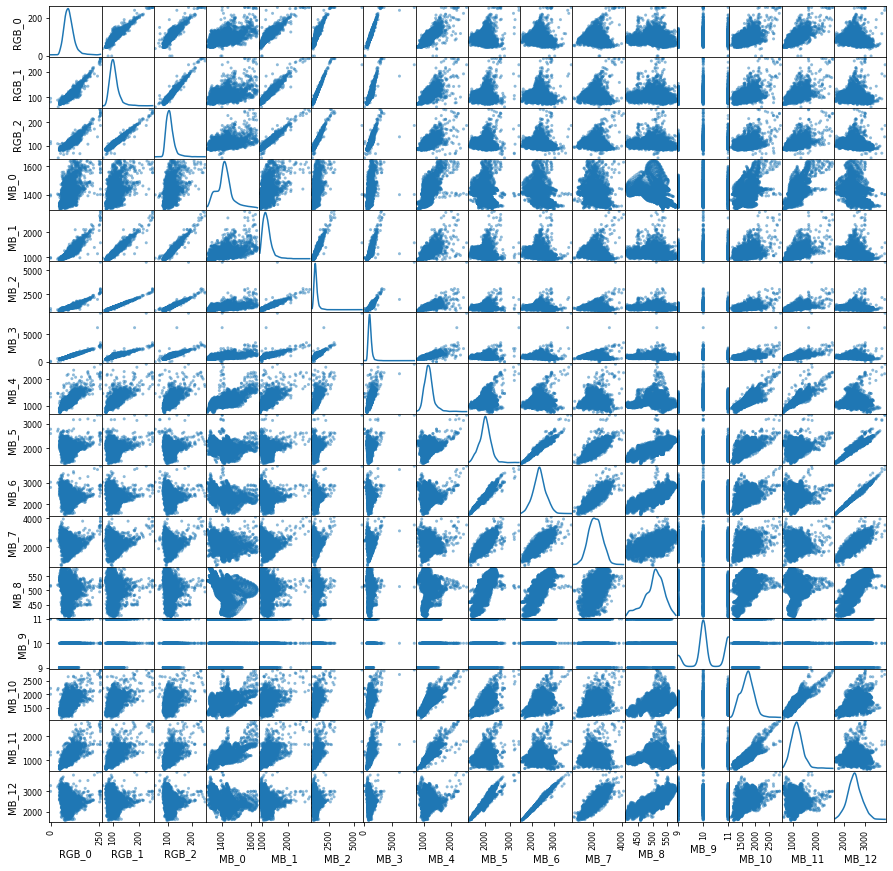

In [10]:
## Plot correlations between channels (RGB + Multiband)
pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(15, 15), diagonal='kde')
plt.show()

In [11]:
## Find channels with max correlations
df_corr = df.corr()[df.columns[3:]]   # Calculate correlation matrix 
df_corr = df.corr().iloc[0:3, 3:]     # Limit is to RGB vs Multiband
df_corr.idxmax(axis = 1)   # Find max correlations

RGB_0    MB_3
RGB_1    MB_2
RGB_2    MB_1
dtype: object

#### Example application: Extract RGB channels from the Multiband image and save as an image

In [12]:
## We detected that RGB channels in Multiband image are -> MB_3 , MB_2, MB_1
mat_my_rgb = mat_mb[:,:, [3, 2, 1]]

In [13]:
## Scaling by min / max
scmin = mat_my_rgb.min()
scmax = mat_my_rgb.max()
print('Max min values : ' + str(scmin) + '  ' + str(scmax))

Max min values : 48  8859


In [14]:
## Scaling by percentiles (more robust to outliers)
scmin = np.percentile(mat_my_rgb, 0.5)
scmax = np.percentile(mat_my_rgb, 99.5)
print('Max min values : ' + str(scmin) + '  ' + str(scmax))

Max min values : 546.435  2179.390000000003


In [15]:
## Scale my RGB image to 0-255
mat_my_rgb_scaled = mat_my_rgb.copy().astype(float)
mat_my_rgb_scaled[mat_my_rgb_scaled < scmin] = scmin
mat_my_rgb_scaled[mat_my_rgb_scaled > scmax] = scmax
mat_my_rgb_scaled = ((mat_my_rgb_scaled - scmin) / (scmax - scmin) * 255).astype(int)

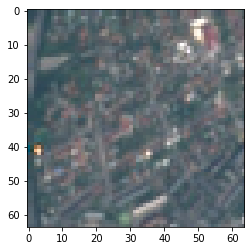

In [16]:
plt.imshow(mat_rgb)
plt.show()

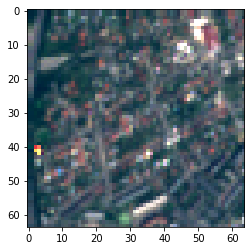

In [17]:
plt.imshow(mat_my_rgb_scaled)
plt.show()

In [18]:
## Save the RBG image
import imageio
imageio.imsave('../outputs/my_rgb_img.png', mat_my_rgb_scaled.astype(np.uint8))